Train a LSTM network to with the training file. Validate the trained model with the valid file. Comment what you are doing in each part of your code. As the better the code, comments and result validation as the better the grade.

In [77]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense, Dropout


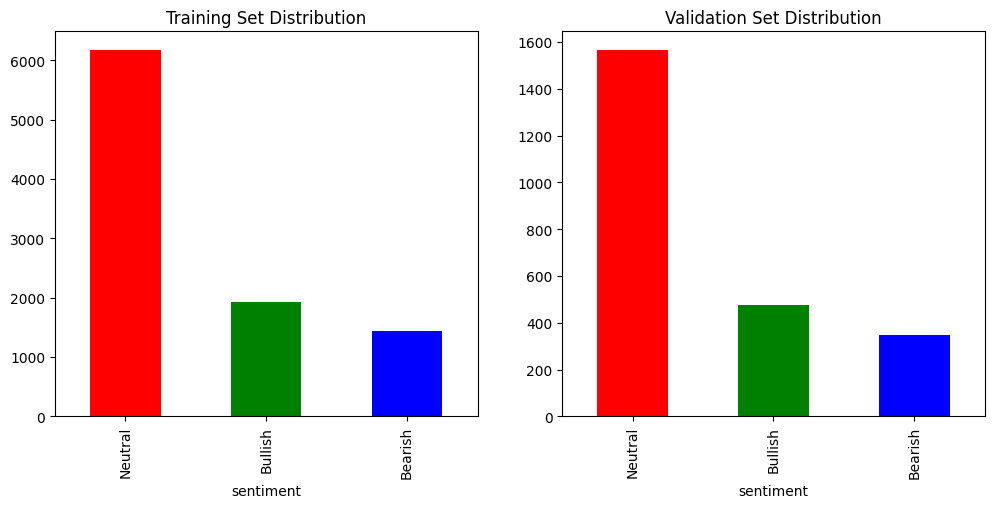

(sentiment
 Neutral    6178
 Bullish    1923
 Bearish    1442
 Name: count, dtype: int64,
 sentiment
 Neutral    1566
 Bullish     475
 Bearish     347
 Name: count, dtype: int64)

In [78]:
# Define sentiment labels
sentiments = {0: "Bearish", 1: "Bullish", 2: "Neutral"}

train_df = pd.read_csv("sent_train.csv")
valid_df = pd.read_csv("sent_valid.csv")

# Map numeric labels to sentiment names
train_df["sentiment"] = train_df["label"].map(sentiments)
valid_df["sentiment"] = valid_df["label"].map(sentiments)

# Plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
train_df["sentiment"].value_counts().plot(kind="bar", ax=axes[0], title="Training Set Distribution", color=["red", "green", "blue"])
valid_df["sentiment"].value_counts().plot(kind="bar", ax=axes[1], title="Validation Set Distribution", color=["red", "green", "blue"])

plt.show()

# Return counts for reference
train_counts = train_df["sentiment"].value_counts()
valid_counts = valid_df["sentiment"].value_counts()

train_counts, valid_counts


In [79]:
##### TOKENIZATION
# Initialize the Tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the training data (only fit on the training data, not validation data)
tokenizer.fit_on_texts(train_df['text'])

# Convert texts to sequences of integers
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_valid = tokenizer.texts_to_sequences(valid_df['text'])

# Check the first sequence in the training data
print(X_train[0])


[5117, 841, 5118, 7, 385, 9, 936, 1131, 3, 1, 2, 7764]


In [80]:
##### PADING
# Define the maximum sequence length (you can experiment with this value)
max_sequence_length = 100  # Adjust this based on your data

pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
# Pad sequences to ensure uniform length across all inputs
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length)
X_valid_padded = pad_sequences(X_valid, maxlen=max_sequence_length)

# Check the shape of the padded data
print(X_train_padded.shape)


(9543, 100)


In [81]:
##### ENCODING LABELS
# Mapping of labels to integers
label_mapping = {"Bearish": 0, "Bullish": 1, "Neutral": 2}

# Convert string labels to integers
y_train = train_df['sentiment'].map(label_mapping).values
y_valid = valid_df['sentiment'].map(label_mapping).values

# One-hot encode the labels
to_categorical = tf.keras.utils.to_categorical
y_train_encoded = to_categorical(y_train)
y_valid_encoded = to_categorical(y_valid)

# Check the one-hot encoded labels
print(y_train_encoded[:5])


[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [82]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Assuming you have the raw sentiment labels (Bearish, Bullish, Neutral) in 'y_train' and 'y_val'
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert raw labels to integers (0, 1, 2)
y_val_encoded = label_encoder.transform(y_val)  # Convert validation labels similarly

y_train_split = to_categorical(y_train_encoded, num_classes=3)
y_val_split = to_categorical(y_val_encoded, num_classes=3)

print(f"y_train_split shape after encoding: {y_train_split.shape}")
print(f"y_val_split shape after encoding: {y_val_split.shape}")

y_train_split shape after encoding: (9543, 3)
y_val_split shape after encoding: (1909, 3)


In [83]:
# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_padded, y_train_encoded, test_size=0.2, random_state=42)

# Check the shape of the resulting splits
print(X_train_split.shape, X_val_split.shape, y_train_split.shape, y_val_split.shape)


(7634, 100) (1909, 100) (7634,) (1909,)


In [84]:
# Define the model parameters
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (plus 1 for padding token)
embedding_dim = 100  # Dimension for the word embeddings (you can change this)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_length), # input_length=max_sequence_length is important because the sequences have been padded
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: Bearish, Bullish, Neutral
])

# Display the model summary
model.summary()

/opt/miniconda3/envs/uie-aa/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Re-compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10

# Train the model
history = model.fit(X_train_split, y_train_split, epochs=num_epochs, validation_data=(X_val_split, y_val_split), verbose=2)